In [3]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd

import numpy as np

# import bokeh
# import scipy
# from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import *

In [4]:
def baselinecorr(data, mz, baseline_start, baseline_end):
    # data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # baseline_start is the end of initial ocv (in min), baseline_end is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], baseline_start)-1
    index2 = getnearpos(data['time/min'], baseline_end+120)
    
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))
    plt.plot([data['time/min'][index] , data['time/min'][index2+3]], [data[str(mz)][index],data[str(mz)][index2+3]], 'o', markersize=6, color = 'purple')

    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2+3]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2+3]-fullfile['time/min'].iloc[time1])
        return m
    
    m= slope( data, mz, index, index2 )
    correct=(m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]

    plt.plot(data['time/min'], correct, '.')
    data[str(mz)] = data[str(mz)]-correct
    #plt.xlim(0,200)
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()    
    
    
    return (data)


In [5]:

#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata, iso=False):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #new as of 
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    #
    #may 2021 calibration
    m = [1.4486, 0.94558, 0.06148247455, 1.690955209, 0.7959230955]

    
    #inf_ar = 288.7462016 * 1.08*10**-9 # demsdata['36']   #as of 2/2019 # use 1.08*10**-9 instead of array if doing 18,18 o2
    if iso ==True:
        inf_ar = 278.6590323 * demsdata['36'].iloc[-20]
    else:
        inf_ar = 278.6590323 * demsdata['36']
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] =  (m[2] * demsdata['2'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['36'] = (m[0] * demsdata['36'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['46'] = (m[1] * demsdata['46'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['48'] = (m[1] * demsdata['48'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)



#     for i in range(len(names)):
#         demsdata[names[i]] = demsdata[names[i]] * vol / R / ( demsdata['temperature/C'] + 273 )

    return (demsdata) 


In [6]:
#plot galvanostatic charge
def plot_dems(chrg_ec, demi, r,  n=2, isotope = False ):
    
    end_ocv= chrg_ec[1]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi, iso= isotope)
    print('charge current (mA): '+ str(np.mean(chrg_ec[1]['I/mA'])))
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv) #chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    oxy_34 = baselinecorr( co2, 34, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)

    if isotope == True:
        co2_46 = baselinecorr( oxy_34, 46, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
        co2_48 = baselinecorr( co2_46, 48, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
        umolesdf = co2_48
    else:
        umolesdf = co2
    
    oxy_36 = baselinecorr( oxy_34, 36, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)

    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
    cap=[]
    curr=[]
    
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[1]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[1]['time/s'].iloc[-1]/60)+3
    
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge+10] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge+10] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[end_charge+10] - np.cumsum(umolesdf['44']).iloc[start_charge]
    umoles_36 = np.cumsum(umolesdf['36']).iloc[end_charge+10]- np.cumsum(umolesdf['36']).iloc[start_charge]
    umoles_34 = np.cumsum(umolesdf['34']).iloc[end_charge+10]- np.cumsum(umolesdf['34']).iloc[start_charge]
    
    if isotope == True:
        umoles_46 = np.cumsum(umolesdf['46']).iloc[end_charge+10]- np.cumsum(umolesdf['46']).iloc[start_charge]
        umoles_48 = np.cumsum(umolesdf['48']).iloc[end_charge+10]- np.cumsum(umolesdf['48']).iloc[start_charge]
        print('46: ', str(umoles_46), ', 48: ', str(umoles_48))
    
    print ('o2: '+ str(umoles_32), 'h2: ' , str(umoles_2), 'co2: ', umoles_44, '18,18O2: ', umoles_36, '16,18O2: ', umoles_34)
    
    j1= 10
    j2= -20
    #ax2.plot(umolesdf['Capacity/mAh'][2:] , 3.6*umolesdf['I/mA'][2:]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['2']/timediff)[j1:j2] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
    ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['44']/timediff)[j1:j2] , 'o:', markersize=4, label = 'CO$_2$', color = 'xkcd:irish green')
    if isotope == True:
        
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['32']/timediff)[j1:j2] , 'o:', markersize=4, label = '$^{16,16}$O$_2$', color= 'xkcd:light blue')
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['34']/timediff)[j1:j2] , 'o:', markersize=4, label = '$^{16,18}$O$_2$', color= 'm')
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['36']/timediff)[j1:j2] , 'o:', markersize=4, label = '$^{18,18}$O$_2$', color = 'xkcd:cerulean')
        #ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['46']/timediff/factor)[j1:j2] , 'o:', markersize=4, label = '46')
        #ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['48']/timediff/factor)[j1:j2] , 'o:', markersize=4, label = '48', color ='xkcd:brown')
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], ((umolesdf['32']+umolesdf['34']+umolesdf['36'])/timediff)[j1:j2] , 'o:', markersize=4, label = 'total O$_2$', color='xkcd:cobalt')
        print( 'total O2 including isotopic labeling: ', str(umoles_36+umoles_32))
    else:
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['32']/timediff)[j1:j2] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange') #label='$^{16,16}$O$_2$'  


    ax2.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    ax2.legend(loc='upper center', bbox_to_anchor=[0.5, 1.2], ncol=4) #, title= 'm/z value')
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue')
    
   # ax.set_ylim([1.6,3.0])
    #ax2.set_ylim([-0.001,0.01])
    rc['font.size'] = 12
#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Zn$^{2+/0}$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32)*10**(6)
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    return

#plt.savefig('/Users/kedzie/Desktop/qual figures/180928_CP cycle 2 dems.png', transparent = True, dpi=600, bbox_inches='tight')



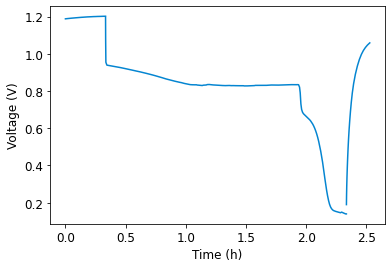

KeyError: 32

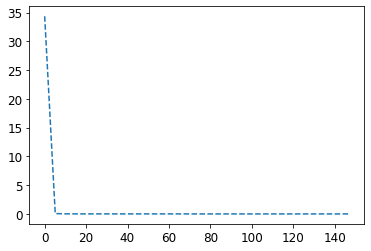

In [18]:
zinc1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210610_Zn-O2_discharge_demsOCVheadspace/')
plt.figure()
for i in range(3):
    plt.plot(zinc1[i]['time/s']/3600, zinc1[i]['Ewe/V'], color = 'xkcd:cerulean')
plt.xlabel('Time (h)'), plt.ylabel('Voltage (V)')
plt.show()

zincheadspace = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210610_Zn-O2_discharge_demsOCVheadspace/210610_Zn-O2_discharge_OCVheadspace_dems_2021-06-10_15.44_30_ch2.txt')
umolesdf = convert_ion_current(zincheadspace)

oxy = baselinecorr( umolesdf, 32, 5, 100)
hydro = baselinecorr( oxy, 2, 5, 100)
co2 = baselinecorr( hydro, 44, 5, 100)

umolesdf=co2


plt.figure()
plt.plot(umolesdf['time/min'], umolesdf['2'], 'o--', label = '2')
plt.plot(umolesdf['time/min'], umolesdf['44'], 'o--', label ='44')
plt.plot(umolesdf['time/min'], umolesdf['32'], 'o--', label ='32')
plt.legend()

The 1th value of this array is: 5.09089
The 10th value of this array is: 50.72069


IndexError: single positional indexer is out-of-bounds

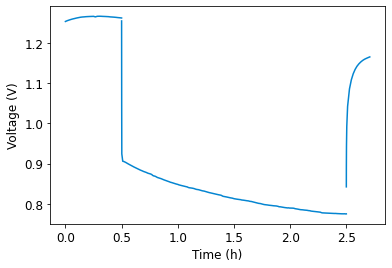

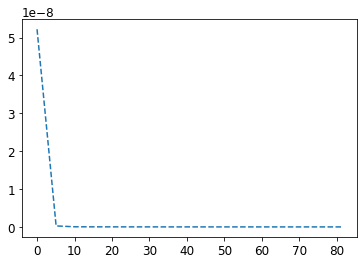

In [60]:
zincrpt = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210611_Zn-O2_discharge_demsheadspace_repeat/210611_Zn-O2_discharge_demsheadspace_2021-06-11_15.00_17_ch2.txt')
znec2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210611_Zn-O2_discharge_demsheadspace_repeat/')

plt.figure()
for i in range(3):
    plt.plot(znec2[i]['time/s']/3600, znec2[i]['Ewe/V'], color = 'xkcd:cerulean')
plt.xlabel('Time (h)'), plt.ylabel('Voltage (V)')

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210611_Zn-O2_discharge_demsheadspace_repeat/210611_Zn-O2_discharge_dems.png', transparent = True, dpi=600, bbox_inches='tight')
#plt.show()

z1_oxy = baselinecorr( zincrpt, 32, 5, 50)
z1_hydro = baselinecorr( z1_oxy, 2, 5, 50)
z1_co2 = baselinecorr( z1_hydro, 44, 5, 50)

z1_umolesdf= z1_co2

plt.figure()
plt.plot(z1_umolesdf['time/min'], z1_umolesdf['2'], 'o--', label = '2')
plt.plot(z1_umolesdf['time/min'], z1_umolesdf['44'], 'o--', label ='44')
#plt.plot(z1_umolesdf['time/min'], z1_umolesdf['32'], 'o--', label ='32')
plt.legend()
plt.ylabel('$\mu$ moles of Gas')
plt.xlabel('Time (min)')



#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210611_Zn-O2_discharge_demsheadspace_repeat/210611_Zn-O2_discharge_dems.png', transparent = True, dpi=600, bbox_inches='tight')



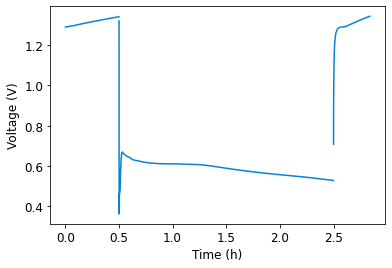

KeyError: 29

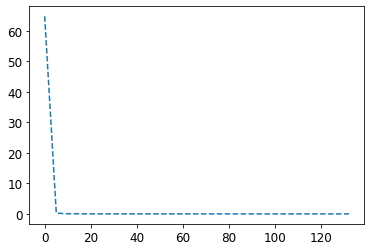

In [11]:
magnesium1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210617_Mg-O2_discharge_headspace_dems/210617_Mg-O2_discharge_headspace_dems_2021-06-17_12.23_51_ch2.txt')

mgec1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210617_Mg-O2_discharge_headspace_dems/')
plt.figure()
for i in range(3):
    plt.plot(mgec1[i]['time/s']/3600, mgec1[i]['Ewe/V'], color = 'xkcd:cerulean')
plt.xlabel('Time (h)'), plt.ylabel('Voltage (V)')
plt.show()

umolesdf1 = convert_ion_current(magnesium1)
oxy1 = baselinecorr( umolesdf1, 32, 5, 80)
hydro1 = baselinecorr( oxy1, 2, 5, 80)
co21 = baselinecorr( hydro1, 44, 5, 80)

umolesdf=co21


plt.figure()
plt.plot(umolesdf1['time/min'], umolesdf1['2'], 'o--', label = '2')
plt.plot(umolesdf1['time/min'], umolesdf1['44'], 'o--', label ='44')
#plt.plot(umolesdf1['time/min'], umolesdf1['32'], 'o--', label ='32')
plt.ylabel('$\mu$ moles of Gas')
plt.xlabel('Time (min)')

plt.legend()

print(umolesdf1['32'].iloc[0])

-0.49965206


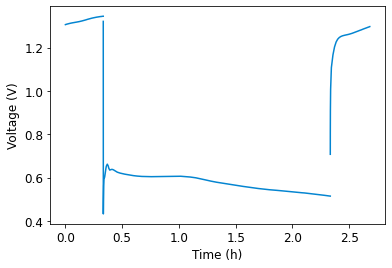

KeyError: -2

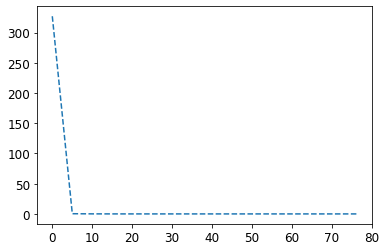

In [64]:
magnesium2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210624_Mg_O2_discharge_headspace_dems/210624_Mg_O2_discharge_headspace_dems2_2021-06-24_15.28_03_ch2.txt')
mag2_ec =folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210624_Mg_O2_discharge_headspace_dems/')
print( mag2_ec[1]['I/mA'].iloc[3])

plt.figure()
for i in range(3):
    plt.plot(mag2_ec[i]['time/s']/3600, mag2_ec[i]['Ewe/V'], color = 'xkcd:cerulean')
plt.xlabel('Time (h)'), plt.ylabel('Voltage (V)')
plt.show()

umolesdf2 = convert_ion_current(magnesium2)
oxy2 = baselinecorr( umolesdf2, 32, 5, 30)
hydro2 = baselinecorr( oxy2, 2, 5, 30)
co22 = baselinecorr( hydro2, 44, 5, 30)

umolesdf2=co22


plt.figure()
plt.plot(umolesdf2['time/min'], umolesdf2['2'], 'o--', label = '2')
plt.plot(umolesdf2['time/min'], umolesdf2['44'], 'o--', label ='44')
plt.plot(umolesdf1['time/min'], umolesdf1['32'], 'o--', label ='32')
plt.ylabel('$\mu$ moles of Gas')
plt.xlabel('Time (min)')

plt.legend()

print(umolesdf2['32'].iloc[0])

charge current (mA): 0.5002733863346615
o2: 23.520026222588427 h2:  0.7351528182178156 co2:  3.64671823171484 18,18O2:  -2.0714135713952735
umoles O2: 23.520026222588427
e per mol: 3.1745068870771083


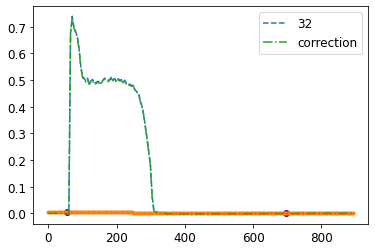

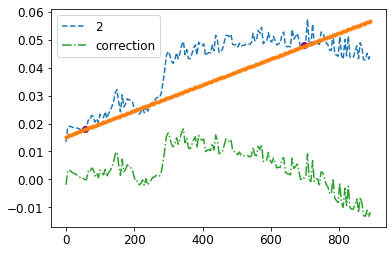

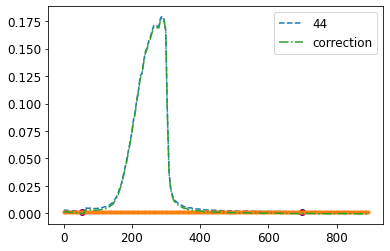

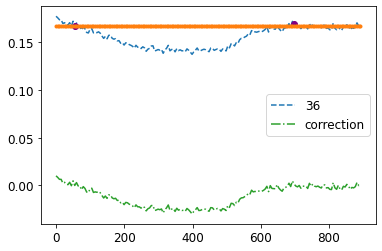

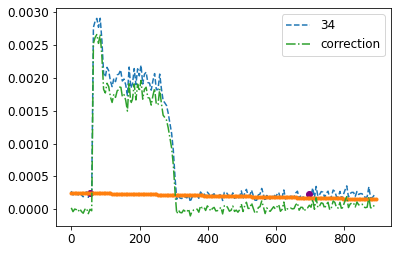

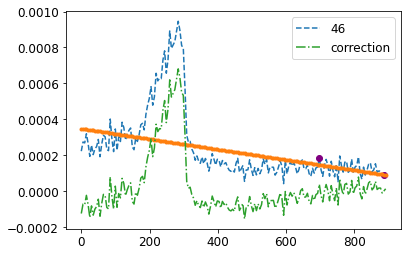

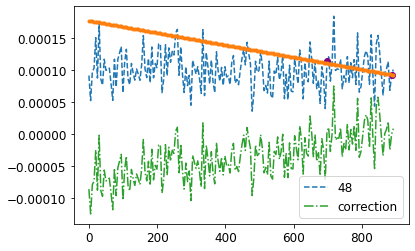

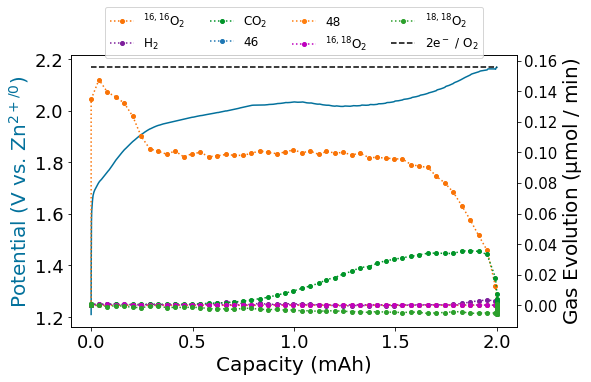

In [45]:
#Zn-O2 DEMS charge

zn_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210811_Zn_O2_charge_dems_500uA/210811_Zn_O2_charge_dems_500uA_2021-08-11_09.29_50.txt')
zn_chrg = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210811_Zn_O2_charge_dems_500uA/')

plot_dems(zn_chrg[0:2], zn_dems, 2, n=2)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210811_Zn_O2_charge_dems_500uA/210811_Zn_O2_charge_dems_500uA.png', transparent = True, dpi=600, bbox_inches='tight')




charge current (mA): 0.5001166841210937
o2: 22.095403119291095 h2:  -3.757503389296566 co2:  2.6237332482006166 18,18O2:  2.614236689958388
umoles O2: 22.095403119291095
e per mol: 3.3781194701500383


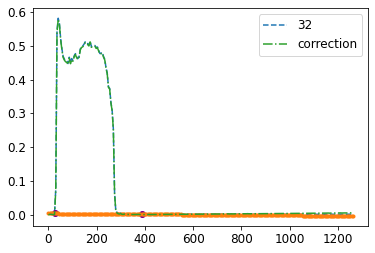

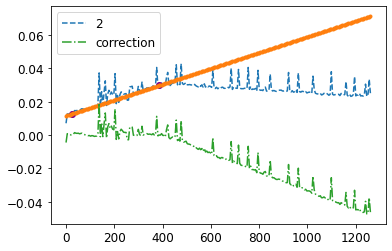

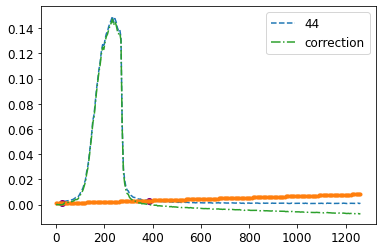

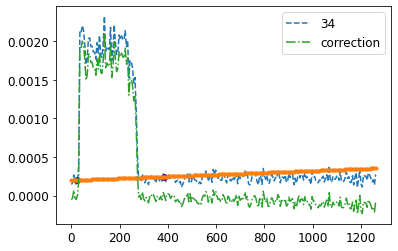

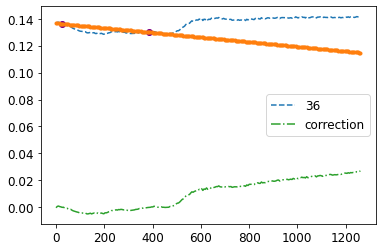

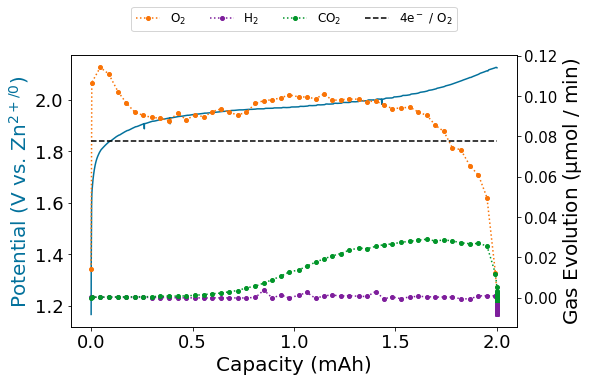

In [430]:

zn_longrest_p = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210909_Zn_O2_longrestpostdischarge_charge_dems/210909_Zn_O2_longrestpostdischarge_charge_dems_2021-09-09_10.03_45_ch1.txt')
zn_longrest = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210909_Zn_O2_longrestpostdischarge_charge_dems/')

plot_dems(zn_longrest[0:2], zn_longrest_p, 1, n=4)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210909_Zn_O2_longrestpostdischarge_charge_dems/210909_Zn_O2_longrestpostdischarge_demscharge.png', transparent = True, dpi=600, bbox_inches='tight')




charge current (mA): 0.5002710574590163
o2: 18.704489201929537 h2:  0.28024048547597796 co2:  1.7270675933713622 18,18O2:  -0.8687820205345015
umoles O2: 18.704489201929537
e per mol: 3.892042394579201


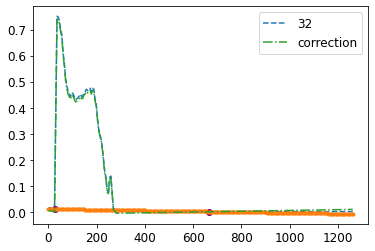

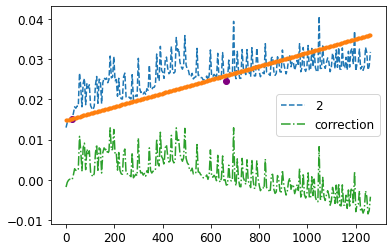

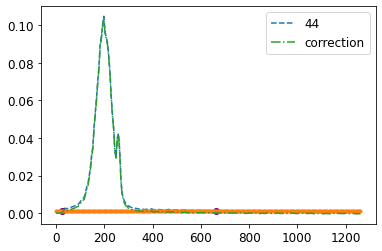

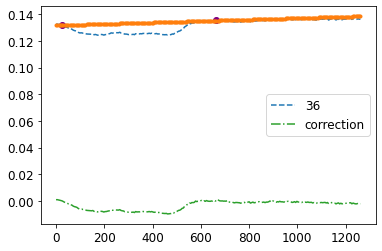

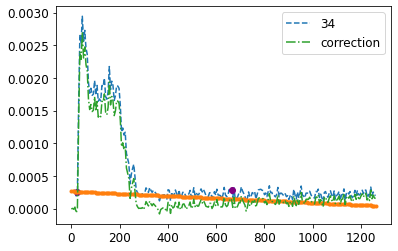

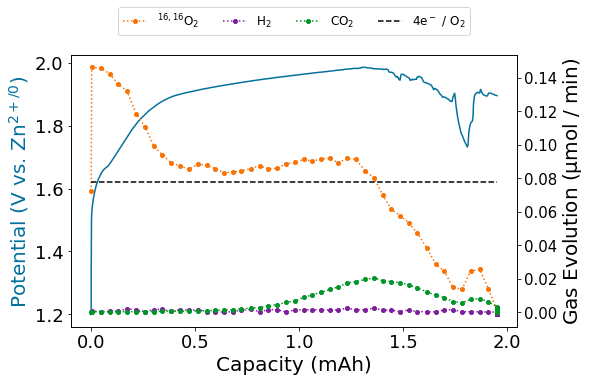

In [18]:
zn_norest_p = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210909_Zn_O2_norest_postdischarge_charge_dems/210909_Zn_O2_norest_postdischarge_charge_dems_2021-09-09_10.03_45_ch2.txt')
zn_norest = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210909_Zn_O2_norest_postdischarge_charge_dems/')
plot_dems(zn_norest[0:2], zn_norest_p, 2, n=4)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210909_Zn_O2_norest_postdischarge_charge_dems/210909_norestpostdischarge_charge_dems.png', transparent = True, dpi=600, bbox_inches='tight')



charge current (mA): 0.5001172240881764
o2: 20.919476665097402 h2:  1.5082149573031638 co2:  3.224627614849755 18,18O2:  0.07765532124429331
umoles O2: 20.919476665097402
e per mol: 3.5680610122053706


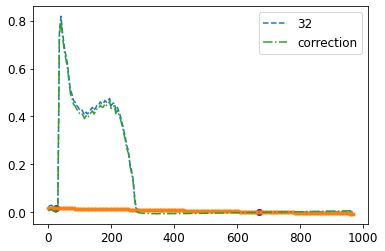

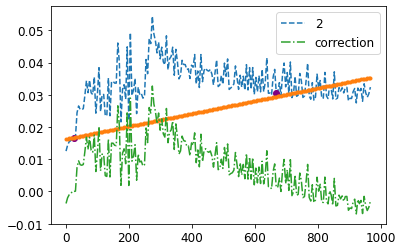

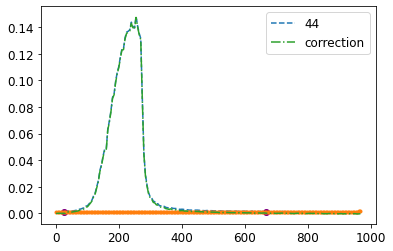

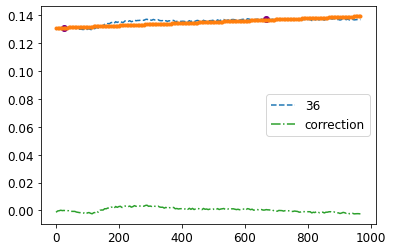

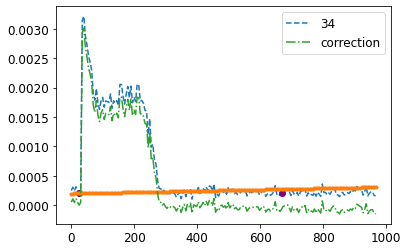

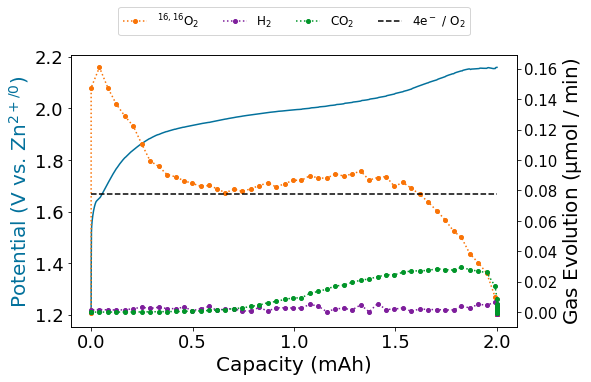

In [17]:
norest_repeat_p = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_norest_postdischarge_dems_2/210913_Zn_O2_norest_postdischarge_dems_chrg_2_2021-09-13_16.47_19.txt')
norest_repeat = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_norest_postdischarge_dems_2/')
#norest_repeat_p[30:35]
norest_repeat_p.iloc[32]=norest_repeat_p.iloc[31]
norest_repeat_p['time/min'].iloc[32] = 159.45694
newdata = norest_repeat_p.drop(index=32)
plot_dems(norest_repeat, norest_repeat_p, 1, n=4)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_norest_postdischarge_dems_2/210913_Zn_norest_dems_rpt.png', transparent = True, dpi=600, bbox_inches='tight')



charge current (mA): 0.5001294236842105
o2: 0.15698144230735053 h2:  -0.3064490078026556 co2:  1.3205339127212954 18,18O2:  8.357000868410193
umoles O2: 0.15698144230735053
e per mol: 237.74718723767435


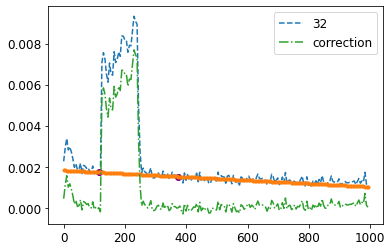

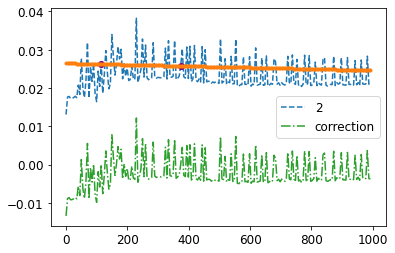

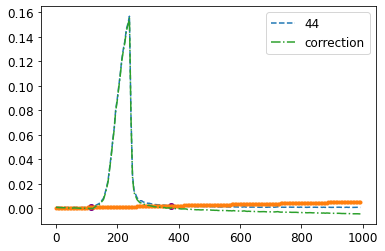

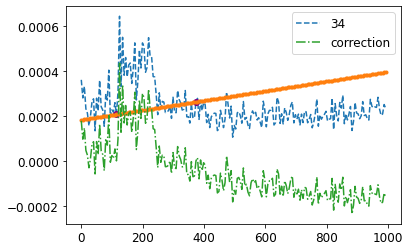

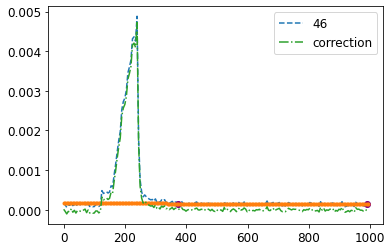

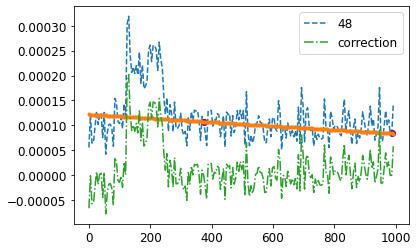

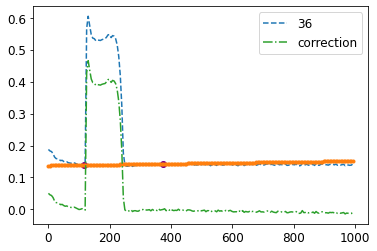

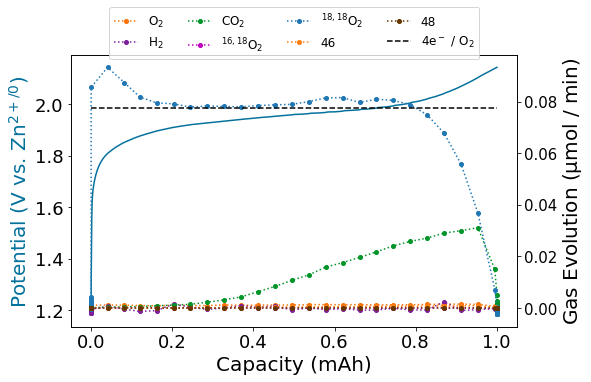

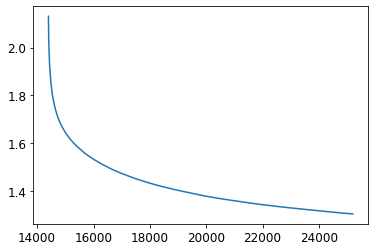

In [439]:
zn18O2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210916_Zn_O2_18O2_disch_charge_dems/210916_Zn_O2_18O2_charge_dems_2021-09-16_14.57_11.txt')
zn18O2_folder = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210916_Zn_O2_18O2_disch_charge_dems/')

plot_dems(zn18O2_folder, zn18O2, 1, n=4, isotope = True)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210916_Zn_O2_18O2_disch_charge_dems/210916_Zn_O2_18O2_disch_charge_dems.png', transparent = True, dpi=600, bbox_inches='tight')

plt.figure()
plt.plot(zn18O2_folder[2]['time/s'], zn18O2_folder[2]['Ewe/V'])

In [407]:
#plot chronoamperometric charge on DEMS
def plot_zn_cccv(chrg_ec, demi, r, ethylene='None', n=2 , percent='None'):
    #oxyi= baselinecorr( demi, 36, chrg_ec[0]['time/s'].iloc[-1], time_min)
    end_ocv= chrg_ec[2]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    oxy = baselinecorr( demi, 32,  chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    #pdb.set_trace()
    #convert ion current to moles of gas for baseline corrected data
    umolesdf = co2
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    
    chrg_ec[2]['Capacity/mA.h'] += chrg_ec[1]['Capacity/mA.h'].iloc[-1]
    if n==1:
        chrg_ec[3]['Capacity/mA.h'] += chrg_ec[2]['Capacity/mA.h'].iloc[-1]
        print(chrg_ec[3]['Capacity/mA.h'].iloc[-1])    
    charge_i= np.mean(chrg_ec[1]['I/mA'])  #normalize charge current by surface area (mA/cm2)
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    cap=[]
    curr=[]
    if n==1:
        new=pd.concat([chrg_ec[1], chrg_ec[2], chrg_ec[3]], sort=True)
    else:
        new=pd.concat([chrg_ec[1], chrg_ec[2]], sort=True)
        
    for j in range( len(umolesdf)):  
        
        index=getnearpos( new['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])
        #print( str(new['time/s'].iloc[index]/60) + ' and '+ str(umolesdf['time/min'].iloc[j]) )

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    
    x= [0.0, chrg_ec[2]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[3]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[5]
    print (umoles_32, umoles_2, umoles_44)
    
    #ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
#     ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff/factor)[5:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    
    if percent=='on':
        ax2.plot(umolesdf['Capacity/mAh'][6:90] , (umolesdf['32']/total_umoles*100)[7:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:tangerine')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['2']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:burnt orange')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['44']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'CO$_2$', color='xkcd:maroon', alpha=0.9)
    else:
        ax2.plot(umolesdf['Capacity/mAh'][6:100] , 3.6*umolesdf['I/mA'][6:100]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
        ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff)[4:90] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
        ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['2']/timediff)[4:90] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
        ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['44']/timediff)[4:90] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36') 
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    ax2.legend( bbox_to_anchor=(0.98, 0.75))
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax.plot(chrg_ec[2]['Capacity/mA.h'], chrg_ec[2]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    if n==1:
        ax.plot(chrg_ec[3]['Capacity/mA.h'], chrg_ec[3]['Ewe/V'],'xkcd:ocean blue', linewidth=3) 

#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Zn/Zn$^{2+}$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    #ax2.set_ylabel('% of Gas Evolved', fontsize=20)
    #ax.set_ylim([1.6,4.0])
    #ax.set_xlim([-0.1,1.1])
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32)*10**(6)
    
    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    print( 'final capacity on charge (mAh): ' + str(chrg_ec[2]['Capacity/mA.h'].iloc[-1]))
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    #plt.title("Cycle " + str(r))
    
    
    fig2,ax4 = plt.subplots(figsize= (8,5), facecolor='None')
    ax5 =ax4.twinx()
    ax4.plot(umolesdf['time/min'][4:90], (umolesdf['32'])[4:90]/timediff, 'o--')
    ax5.plot(chrg_ec[0]['time/s']/60, chrg_ec[0]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax5.plot(chrg_ec[1]['time/s']/60, chrg_ec[1]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax5.plot(chrg_ec[2]['time/s']/60, chrg_ec[2]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax4.set_xlim(90,295)
    

    return





8.68491195787434 0.07368293742018743 1.2209428985201558
final capacity on charge (mAh): 0.9207051164574094
umoles O2: 8.68491195787434
e per mol: 3.9554676408679765
0.1404933631420136


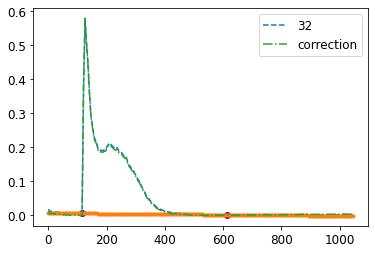

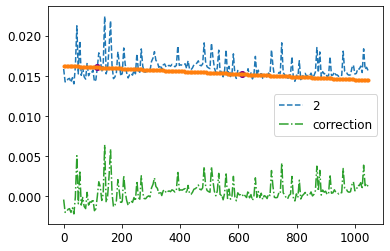

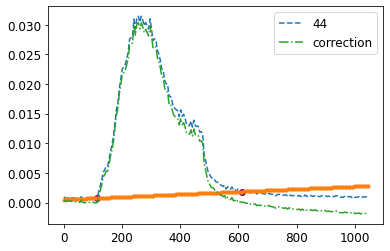

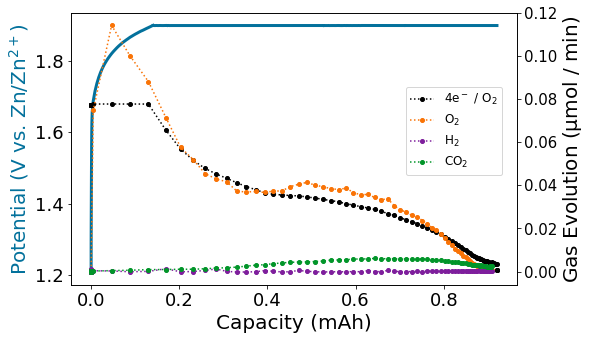

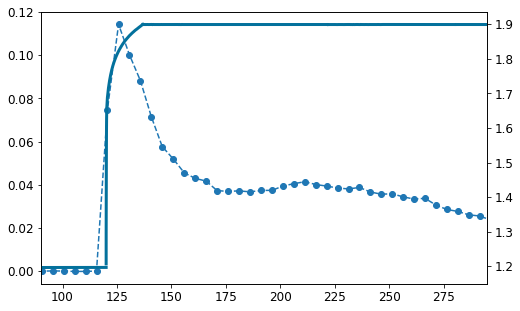

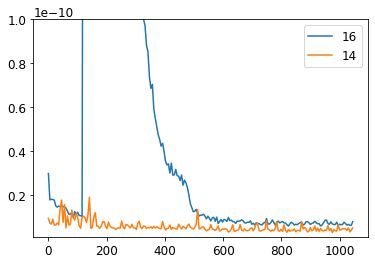

In [440]:
zn_o2_cc_cv = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210930_Zn_O2_CCCVcharge_1-9Vhold_dems/210930_Zn_O2_CCCVcharge_1-9Vhold_dems_2021-09-30_15.55_17_ch2.txt')
zn_o2_cc_cv_ec =find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210930_Zn_O2_CCCVcharge_1-9Vhold_dems/')

plot_zn_cccv(zn_o2_cc_cv_ec, zn_o2_cc_cv, r = 1, n=4)

plt.figure()
plt.plot(zn_o2_cc_cv['time/min'], zn_o2_cc_cv['16'], label ='16')
plt.plot(zn_o2_cc_cv['time/min'], zn_o2_cc_cv['14'], label = '14')
plt.ylim([10**-12, 1*10**-10])
plt.legend()

print(zn_o2_cc_cv_ec[1]['Capacity/mA.h'].iloc[-1])

415.00978074401985
119.99999764909347
295.0097830949264
3.7479240007894425 0.0233424595852987 -0.012430026628383833
final capacity on charge (mAh): 0.296619918404354
umoles O2: 3.7479240007894425
e per mol: 2.9529237639177808


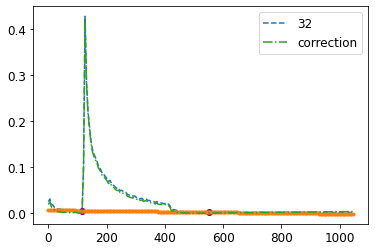

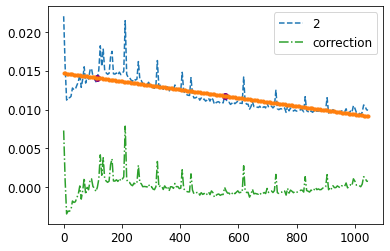

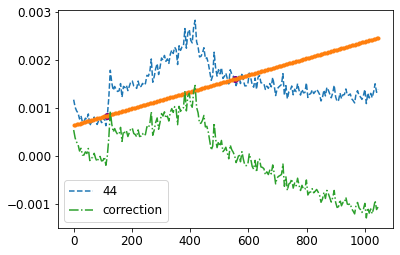

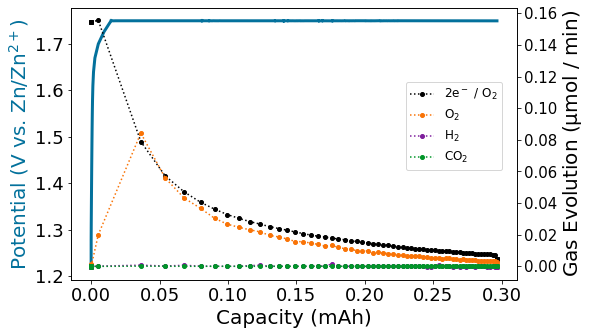

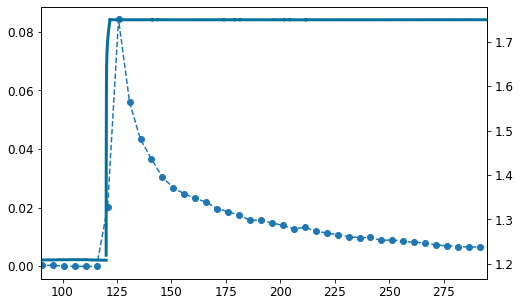

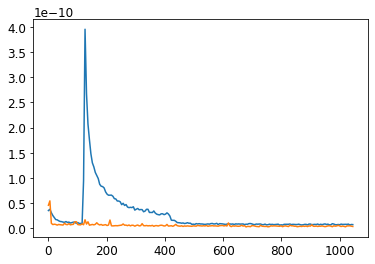

In [442]:
zn_o2_cccv_175 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210930_Zn_O2_CCCVcharge_1-75Vhold_dems/210930_Zn_O2_CCCVcharge_1-75Vhold_dems_2021-09-30_15.55_17_ch1.txt')
zn_o2_cccv_175ec =find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210930_Zn_O2_CCCVcharge_1-75Vhold_dems/')
print(zn_o2_cccv_175ec[2]['time/s'].iloc[-1]/60)
print(zn_o2_cccv_175ec[0]['time/s'].iloc[-1]/60)
print(zn_o2_cccv_175ec[2]['time/s'].iloc[-1]/60-zn_o2_cccv_175ec[0]['time/s'].iloc[-1]/60)

plot_zn_cccv(zn_o2_cccv_175ec, zn_o2_cccv_175, r = 1, n=2)

# ax.plot(zn_o2_cccv_175['time/min'],zn_o2_cccv_175['32'], 'o--')
# ax2.plot(zn_o2_cccv_175ec[0]['time/s']/60,zn_o2_cccv_175ec[0]['Ewe/V'] , 'orange')
# ax2.plot(zn_o2_cccv_175ec[1]['time/s']/60,zn_o2_cccv_175ec[1]['Ewe/V'], 'orange' )
# ax2.plot(zn_o2_cccv_175ec[2]['time/s']/60,zn_o2_cccv_175ec[2]['Ewe/V'] , 'orange')



plt.figure()
plt.plot(zn_o2_cccv_175['time/min'], zn_o2_cccv_175['16'])
plt.plot(zn_o2_cccv_175['time/min'], zn_o2_cccv_175['14'])

125.70027999999999


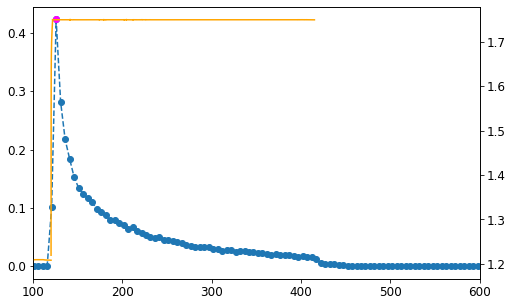

In [443]:
fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
ax2=ax.twinx()

ax.plot(zn_o2_cccv_175['time/min'],zn_o2_cccv_175['32'], 'o--')
ax2.plot(zn_o2_cccv_175ec[0]['time/s']/60,zn_o2_cccv_175ec[0]['Ewe/V'] , 'orange')
ax2.plot(zn_o2_cccv_175ec[1]['time/s']/60,zn_o2_cccv_175ec[1]['Ewe/V'], 'orange' )
ax2.plot(zn_o2_cccv_175ec[2]['time/s']/60,zn_o2_cccv_175ec[2]['Ewe/V'] , 'orange')

ax.set_xlim(100,600)

ax.plot(zn_o2_cccv_175['time/min'].iloc[25], zn_o2_cccv_175['32'].iloc[25], 'o', color ='magenta')
print(zn_o2_cccv_175['time/min'].iloc[25])

charge current (mA): 0.10030025337067545
o2: 44.93576283787079 h2:  5.45715922190893 co2:  0.39566099911043606 18,18O2:  1.844695099999999e-07
umoles O2: 44.93576283787079
e per mol: 0.8328328645158002
124.56083000000001


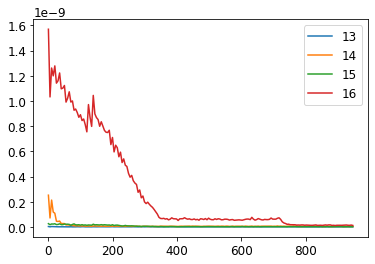

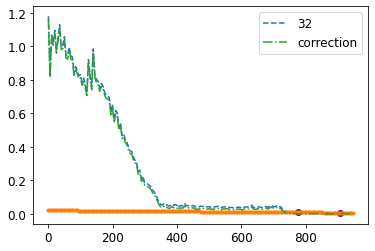

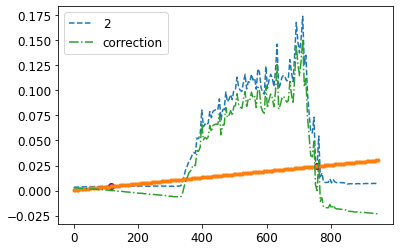

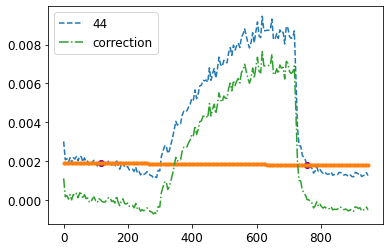

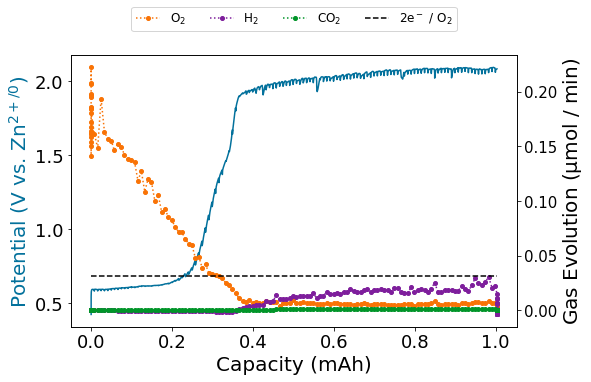

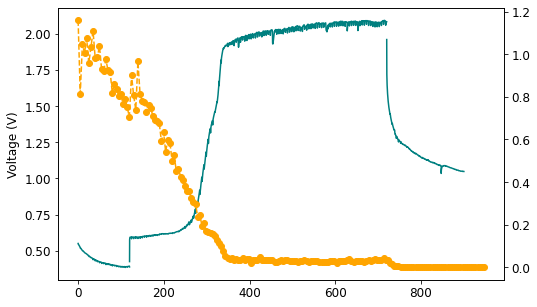

In [394]:
h2o2_ch = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210929_Zn_O2_h2o2_charge_argon_dems/210929_Zn_O2_h2o2_charge_argon_dems_2021-09-29_20.09_16.txt')
h2o2_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210929_Zn_O2_h2o2_charge_argon_dems/')
plt.figure()
i = 13
plt.plot(h2o2_ch['time/min'], h2o2_ch[str(i)], label = str(i))
plt.plot(h2o2_ch['time/min'], h2o2_ch[str(i+1)], label = str(i+1))
plt.plot(h2o2_ch['time/min'], h2o2_ch[str(i+2)], label = str(i+2))
plt.plot(h2o2_ch['time/min'], h2o2_ch[str(i+3)], label = str(i+3))
plt.legend()

plot_dems(h2o2_fold, h2o2_ch, r=1, n=2)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210929_Zn_O2_h2o2_charge_argon_dems/210929_Zn_O2_h2o2_charge_dems.png', transparent = True, dpi=600, bbox_inches='tight')


fig,ax2 = plt.subplots(figsize= (8,5), facecolor='None')
ax=ax2.twinx()

ax.plot(h2o2_ch['time/min'],h2o2_ch['32'], 'o--', color = 'orange')
ax2.plot(h2o2_fold[0]['time/s']/60,h2o2_fold[0]['Ewe/V'] , 'teal')
ax2.plot(h2o2_fold[1]['time/s']/60,h2o2_fold[1]['Ewe/V'], 'teal' )
ax2.plot(h2o2_fold[2]['time/s']/60,h2o2_fold[2]['Ewe/V'] , color = 'teal')
ax.set_xlabel('Time (min)')
ax2.set_ylabel('Voltage (V)')
ax.set_ylabel('Moles of oxygen ($\mu$mol)')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210929_Zn_O2_h2o2_charge_argon_dems/210929_Zn_O2_h2o2_charge_dems.png', transparent = True, dpi=600, bbox_inches='tight')

#ax.plot(h2o2_ch['time/min'].iloc[25], h2o2_ch['32'].iloc[25], 'o', color ='magenta')
print(h2o2_ch['time/min'].iloc[25])

charge current (mA): 0.10031106386033058
o2: 5.888840807338158 h2:  1.1787900883571891 co2:  1.3590476875306907 18,18O2:  0.1792694780171201
umoles O2: 5.888840807338158
e per mol: 6.355719034980499


Text(0, 0.5, 'Moles of oxygen ($\\mu$mol)')

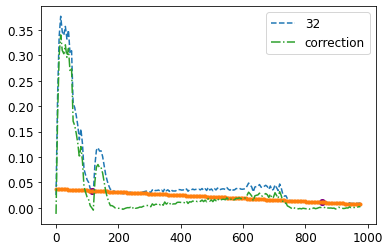

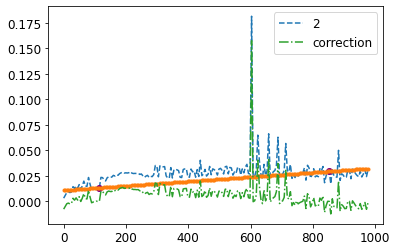

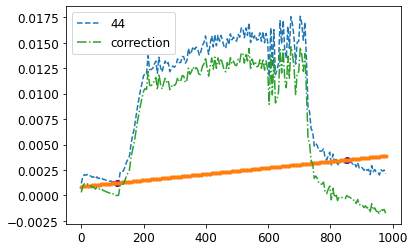

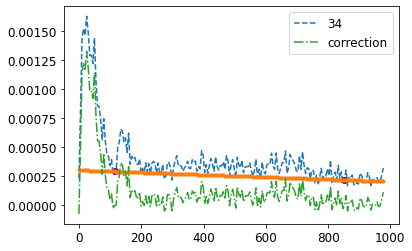

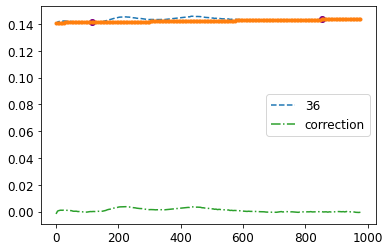

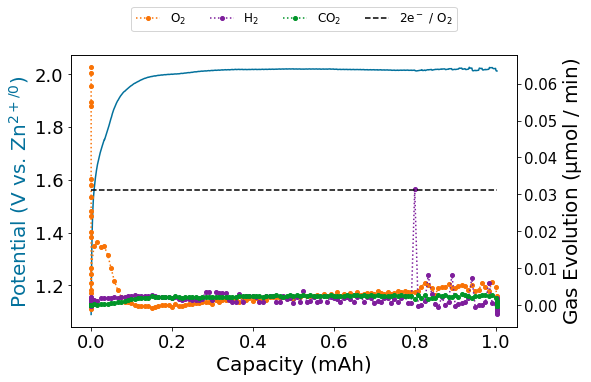

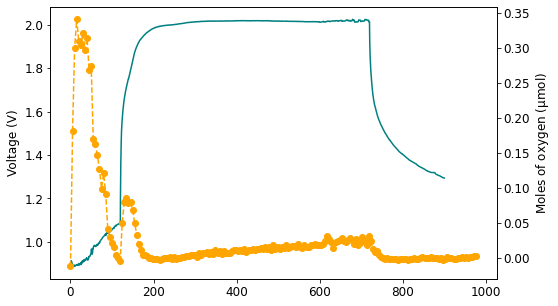

In [441]:
h2o2withelyte_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211011_Zn_H2O2_ZnOTf2elyte_chrg_argon_dems/211011_Zn_H2O2_ZnOTf2elyte_chrg_argon_dems_2021-10-11_18.10_31.txt')
h2o2withelyte_ec = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211011_Zn_H2O2_ZnOTf2elyte_chrg_argon_dems/')



plot_dems(h2o2withelyte_ec, h2o2withelyte_dems, r=1, n=2)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211011_Zn_H2O2_ZnOTf2elyte_chrg_argon_dems/211011_Zn_H2O2_ZnOTf2elyte_charge.png', transparent = True, dpi=600, bbox_inches='tight')

fig,ax2 = plt.subplots(figsize= (8,5), facecolor='None')
ax=ax2.twinx()
ax.plot(h2o2withelyte_dems['time/min'],h2o2withelyte_dems['32'], 'o--', color = 'orange')
ax2.plot(h2o2withelyte_ec[0]['time/s']/60,h2o2withelyte_ec[0]['Ewe/V'] , 'teal')
ax2.plot(h2o2withelyte_ec[1]['time/s']/60,h2o2withelyte_ec[1]['Ewe/V'], 'teal' )
ax2.plot(h2o2withelyte_ec[2]['time/s']/60,h2o2withelyte_ec[2]['Ewe/V'] , color = 'teal')
ax.set_xlabel('Time (min)')
ax2.set_ylabel('Voltage (V)')
ax.set_ylabel('Moles of oxygen ($\mu$mol)')
#ax.set_xlim(100,600)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211011_Zn_H2O2_ZnOTf2elyte_chrg_argon_dems/211011_Zn_H2O2_ZnOTf2elyte_vstimedata.png', transparent = True, dpi=600, bbox_inches='tight')







charge current (mA): 0.5002921112830188
o2: 6.260495748098732 h2:  -0.06797241928502536 co2:  1.5673615804635763 18,18O2:  3.563054441784747
total O2 including isotopic labeling:  9.823550189883479
umoles O2: 6.260495748098732
e per mol: 5.963441609166116


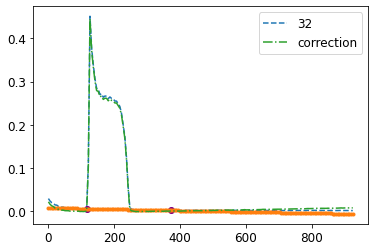

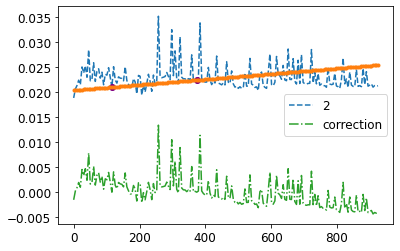

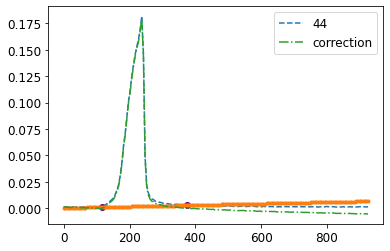

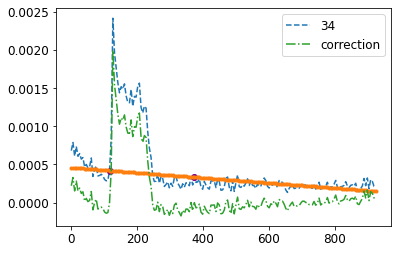

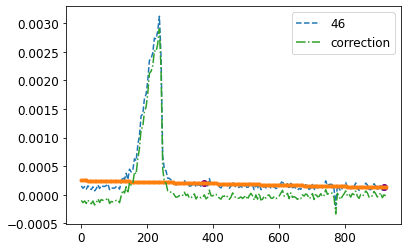

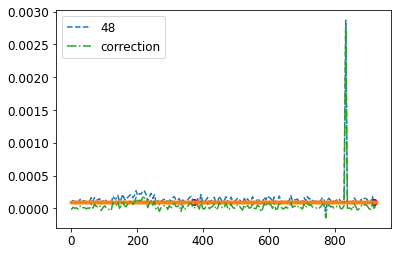

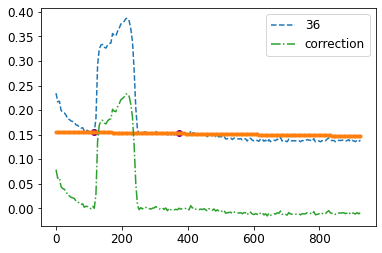

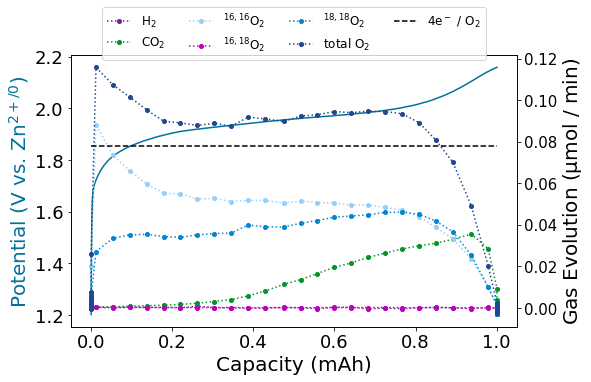

In [37]:
isotope_halfdisch_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_halfdisch16O2_halfdisch18O2_dems/211019_Zn_halfdisch16O2_halfdisch18O2_dems_chrg_2021-10-19_16.30_17.txt')
isotope_halfdisch_folder = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_halfdisch16O2_halfdisch18O2_dems/')

plot_dems(isotope_halfdisch_folder, isotope_halfdisch_dems, r=1, n=4, isotope=True)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_halfdisch16O2_halfdisch18O2_dems/211019_Zn_halfdisch16O2_halfdisch18O2_chrg_dems.png', transparent = True, dpi=600, bbox_inches='tight')




charge current (mA): 0.5002714683773586
o2: 3.4078195710153203 h2:  -0.3006246794866313 co2:  1.647158156411463 18,18O2:  5.98934354028709
total O2 including isotopic labeling:  9.39716311130241
umoles O2: 3.4078195710153203
e per mol: 10.955017194507791


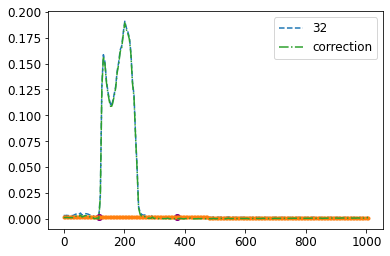

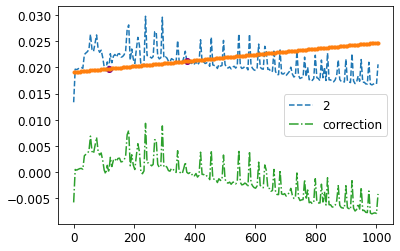

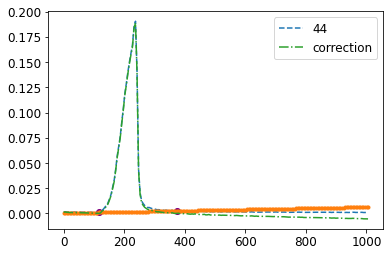

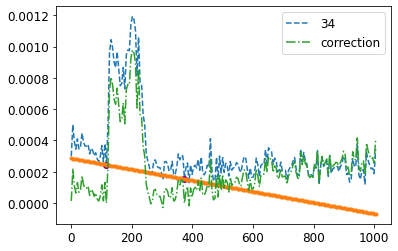

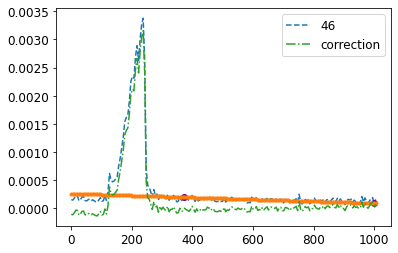

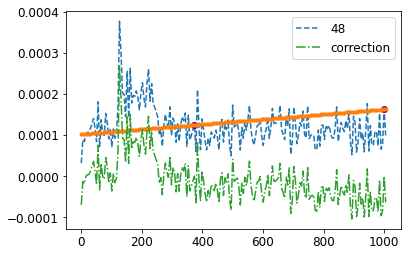

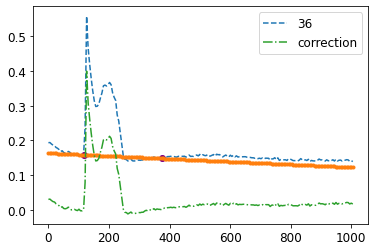

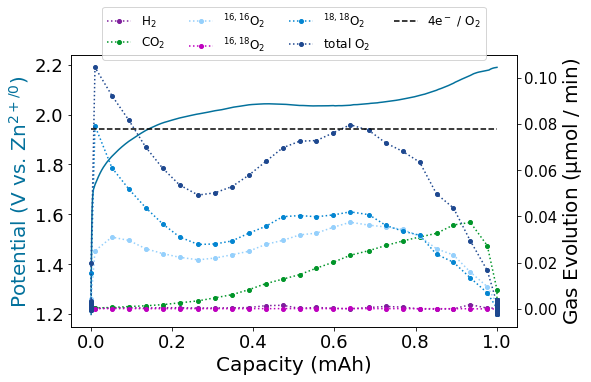

In [38]:
switch_isotope_halfdisch_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211025_Zn_switch_halfdisch18O2_dems_chrg/211025_Zn_switch_halfdisch18O2_dems_chrg_2021-10-25_13.04_17.txt')
switch_isotope_halfdisch_folder = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211025_Zn_switch_halfdisch18O2_dems_chrg/')

plot_dems(switch_isotope_halfdisch_folder, switch_isotope_halfdisch_dems, r=1, n=4, isotope=True)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211025_Zn_switch_halfdisch18O2_dems_chrg/211025_Zn_switch_halfdisch18O2_dems_chrg.png', transparent = True, dpi=600, bbox_inches='tight')





charge current (mA): 0.5002841777205882
o2: 0.05185326363887531 h2:  -0.28084116914112595 co2:  0.0017850942793517506 18,18O2:  -0.5113626529000735
umoles O2: 0.05185326363887531
e per mol: 719.9852861970311


Text(0, 0.5, 'Moles of oxygen ($\\mu$mol)')

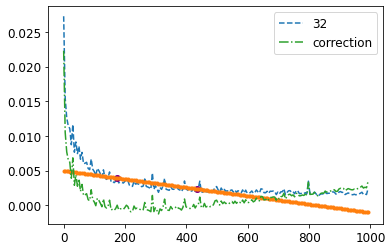

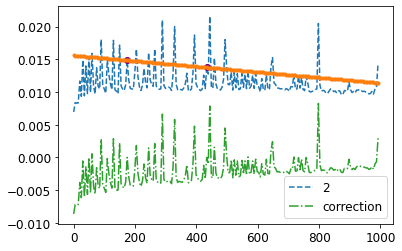

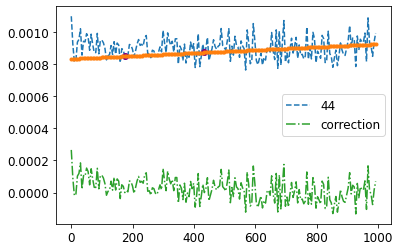

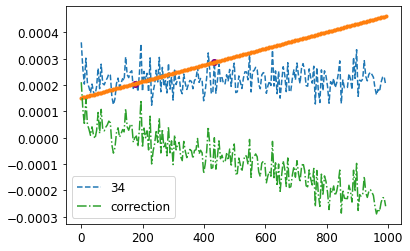

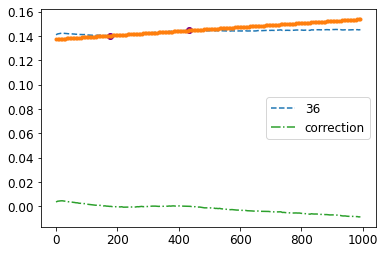

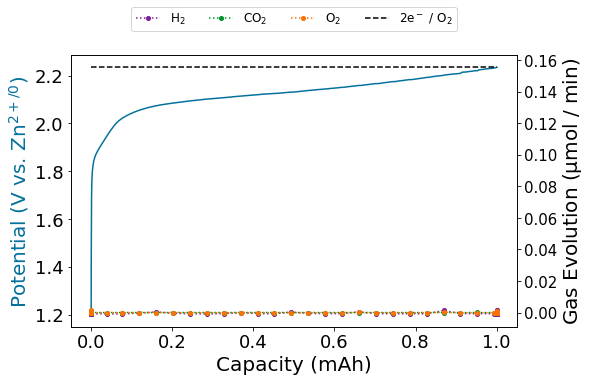

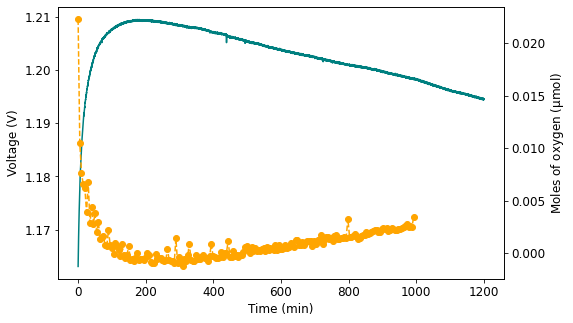

In [41]:
ocv_after_discharge_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/211013_Zn-O2-cycle_dems_ocv_postdisch_2021-10-13_14.18_31.txt')
ocv_after_discharge_folder = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/')

plot_dems(ocv_after_discharge_folder[0:2], ocv_after_discharge_dems, r=1)

fig,ax2 = plt.subplots(figsize= (8,5), facecolor='None')
ax=ax2.twinx()

ax.plot(ocv_after_discharge_dems['time/min'],ocv_after_discharge_dems['32'], 'o--', color = 'orange')
ax2.plot(ocv_after_discharge_folder[3]['time/s']/60,ocv_after_discharge_folder[3]['Ewe/V'] , 'teal')

ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Voltage (V)')
ax.set_ylabel('Moles of oxygen ($\mu$mol)')

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/211013_Zn-O2_ocv_postdisch_dems.png', transparent = True, dpi=600, bbox_inches='tight')



charge current (mA): 0.5002841777205882
o2: 5.023222550378717 h2:  0.6586733106110195 co2:  1.8955889729027589 18,18O2:  -0.08076143210931236 16,18O2:  0.017955616098708466
umoles O2: 5.023222550378717
e per mol: 7.432198451663473


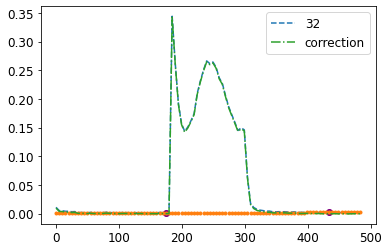

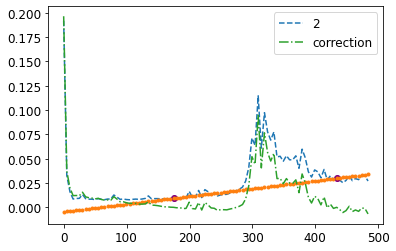

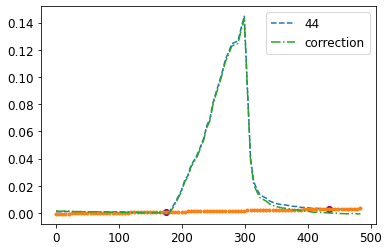

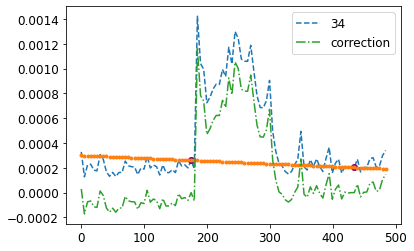

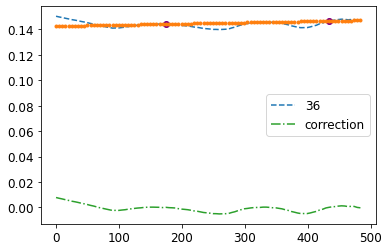

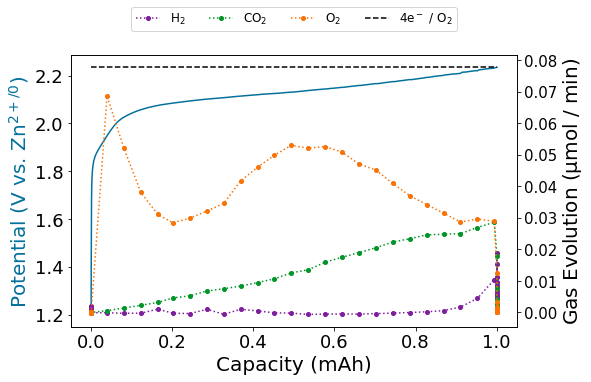

In [10]:
charge_after_ocv_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/211013_Zn-O2-cycle_dems_chrg_2021-10-14_10.39_29.txt')
charge_after_ocv_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/')
plot_dems(charge_after_ocv_fold, charge_after_ocv_dems, r=1, n=4)

